dataset：是构建数据集，支持索引  
dataloader：是构建mini-batch的方法，每次取一小部分数据  

考虑以下代码
~~~python
for epoch in range(training_epochs):    
    for i in range(total_batch):      
        pass
~~~

epoch：所有样本都进行了一次前馈和反馈，称为一次epoch  
Batch-Size：每次进行前馈反馈的样本批量的大小  
Iteration：内层迭代执行了多少次，比如1000个样本，batch=10，则Iteration为100

对于 `dataloader(batch_size = 2, shuffle=True)`，是将数据集随机打乱然后每两个组成一队，

其中，Dataset 是一个抽象类，只能被继承，不能直接实例化，且必须实现  
`init`：初始化，如果数据集不大，可以全部读入到内存；否则将文件表放入内存  
`getitem`：通过索引返回数据集的元素  
`len`：返回数据集的样本数，即行数   
而DataLoader 不是抽象类，可以直接实例化

```py
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DiabetesDataset(Dataset):
    def __init__(self):
        super().__init__()
    
    def __getitem__(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return 
    
dataset = DiabetesDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=2,
                          shuffle=True,
                          num_workers=2)    # 读取数据的并行线程数
```

下面是完整代码：

In [97]:
# 加载数据集
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

class DiabetesDataset(Dataset):
    def __init__(self, path):
        xy = np.loadtxt(path, delimiter=',', dtype=np.float32)
        self.len = xy.shape[0]
        self.x_data = torch.from_numpy(xy[:, :-1])
        self.y_data = torch.from_numpy(xy[:, [-1]])
    
    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]
    
    def __len__(self):
        return self.len
    
dataset = DiabetesDataset('./dataset/diabetes.csv')
train_loader = DataLoader(dataset=dataset,
                         batch_size=32,
                         shuffle=True)

In [98]:
# 定义模型
class DiabetesModel(torch.nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.linear1 = torch.nn.Linear(8, 6)
        self.linear2 = torch.nn.Linear(6, 4)
        self.linear3 = torch.nn.Linear(4, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.linear1(x))
        x = self.sigmoid(self.linear2(x))
        x = self.sigmoid(self.linear3(x))
        return x

model = DiabetesModel()

In [99]:
# 构造损失函数和优化器
criterion = torch.nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

/Users/liyang/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [100]:
# 训练模型
loss_list = []
for epoch in range(1000):
    train_loss = 0.0
    count = 0
    for i,data in enumerate(train_loader, 0):
        inputs, labels = data

        # 前馈
        y_pred = model(inputs)
        loss = criterion(y_pred, labels)

        # 反馈
        optimizer.zero_grad()
        loss.backward()

        # 更新
        optimizer.step()

        train_loss += loss.item()
        count = i
    loss_list.append(train_loss / count)


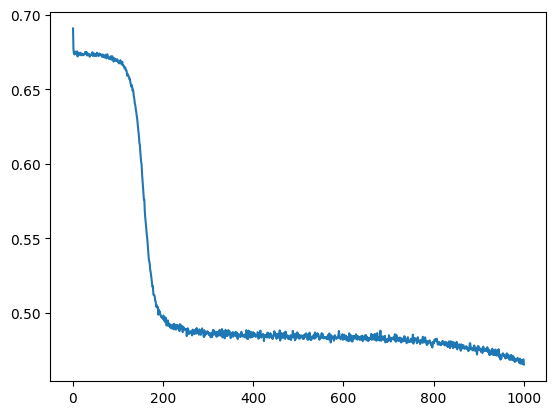

In [101]:
import matplotlib.pyplot as plt
size = len(loss_list)
x = np.arange(1, size + 1, 1)

plt.plot(x, loss_list)
plt.show()